In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [2]:
# Load swissprot sequences, annotations, and cafa3 annotations
import os
swissprot_dir = '/projects/deepgreen/pstjohn/swissprot_go_annotation'

swissprot = pd.read_parquet(os.path.join(swissprot_dir, 'parsed_swissprot_uniref_clusters.parquet'))
go_terms = pd.read_parquet(os.path.join(swissprot_dir, 'swissprot_quickgo.parquet'))
cafa3_accessions = np.load(os.path.join(swissprot_dir, 'cafa3_accessions.npz'), allow_pickle=True)

<AxesSubplot:ylabel='Frequency'>

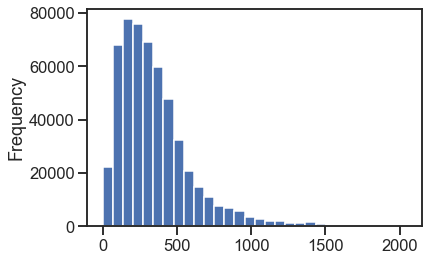

In [3]:
# Prepare for fairseq input
swissprot['str_sep_sequence'] = swissprot.sequence.str.replace("", " ").str.strip()

# Restrict swissprot to those with GO annotations
swissprot_annotated = swissprot[swissprot.accession.isin(go_terms['GENE PRODUCT ID'].unique())]
swissprot_annotated.length.plot.hist(range=(0, 2048), bins=30)

In [4]:
uniref50_clusters = swissprot_annotated['UniRef50 ID'].unique()

# Remove cafa3 target data from swissprot data
uniref50_nocafa3 = np.array(list(set(uniref50_clusters) - set(cafa3_accessions['test'])))

# Split swissprot into training and test
print(len(uniref50_nocafa3))
np.random.seed(1)
np.random.shuffle(uniref50_nocafa3)
test, valid, train = np.split(uniref50_nocafa3, [3000, 6000])

swissprot_train = swissprot_annotated[swissprot_annotated['UniRef50 ID'].isin(train)].sample(frac=1., random_state=1)
swissprot_valid = swissprot_annotated[swissprot_annotated['UniRef50 ID'].isin(valid)].sample(frac=1., random_state=1)
swissprot_test = swissprot_annotated[swissprot_annotated['UniRef50 ID'].isin(test)].sample(frac=1., random_state=1)

174018


In [7]:
# Create the sequence input data files
swissprot_dest_dir = '/projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_swissprot'

swissprot_train['str_sep_sequence'].to_csv(os.path.join(swissprot_dest_dir, 'input0', 'train.raw'), index=False, header=None)
swissprot_valid['str_sep_sequence'].to_csv(os.path.join(swissprot_dest_dir, 'input0', 'valid.raw'), index=False, header=None)
swissprot_test['str_sep_sequence'].to_csv(os.path.join(swissprot_dest_dir, 'input0', 'test.raw'), index=False, header=None)

In [8]:
# Create the ontology object and backpropogate GO labels

import sys
sys.path.append('/home/pstjohn/Research/20201119_fairseq/go_annotation')

from ontology import Ontology
ont = Ontology()
ont.total_nodes

32012

In [9]:
grouped_go_terms = go_terms.groupby('GENE PRODUCT ID')['GO TERM'].apply(lambda x: x.values)

In [14]:
from tqdm import tqdm

In [30]:
with open(os.path.join(swissprot_dest_dir, 'label', 'train.label'), 'w') as f:
    for row in tqdm(swissprot_train.accession):
        arr = ont.terms_to_indices(ont.get_ancestors(grouped_go_terms.loc[row]))
        f.write(' '.join(np.array(arr, dtype=str)))
        
with open(os.path.join(swissprot_dest_dir, 'label', 'valid.label'), 'w') as f:
    for row in tqdm(swissprot_valid.accession):
        arr = ont.terms_to_indices(ont.get_ancestors(grouped_go_terms.loc[row]))
        f.write(' '.join(np.array(arr, dtype=str)))
        
with open(os.path.join(swissprot_dest_dir, 'label', 'test.label'), 'w') as f:
    for row in tqdm(swissprot_test.accession):
        arr = ont.terms_to_indices(ont.get_ancestors(grouped_go_terms.loc[row]))
        f.write(' '.join(np.array(arr, dtype=str)))

100%|██████████| 9088/9088 [00:04<00:00, 2266.80it/s]


In [35]:
!fairseq-preprocess \
    --only-source \
    --srcdict /projects/deepgreen/pstjohn/uniparc_training_data/dict.txt \
    --trainpref /projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_swissprot/input0/train.raw \
    --validpref /projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_swissprot/input0/valid.raw \
    --testpref /projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_swissprot/input0/test.raw \
    --destdir /projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_swissprot/input0 \
    --workers 60

2020-12-22 19:24:31 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='/projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_swissprot/input0', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=True, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=True, scoring='bleu', seed=1, source_lang=None, srcdict='/projects/deepgreen/pstjohn/uniparc_training_data/dict.txt', target_lang=None, task='translation', tensorboard_logdir=None, testpref='/projects/deepgreen/pstjohn/swis

In [44]:
# Create the sequence input data files
swissprot_debug_dest_dir = '/projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_swissprot_debug'

swissprot_train_debug = swissprot_train.sample(100)
swissprot_valid_debug = swissprot_valid.sample(100)
swissprot_test_debug = swissprot_test.sample(100)

swissprot_train_debug['str_sep_sequence'].to_csv(os.path.join(swissprot_debug_dest_dir, 'input0', 'train.raw'), index=False, header=None)
swissprot_valid_debug['str_sep_sequence'].to_csv(os.path.join(swissprot_debug_dest_dir, 'input0', 'valid.raw'), index=False, header=None)
swissprot_test_debug['str_sep_sequence'].to_csv(os.path.join(swissprot_debug_dest_dir, 'input0', 'test.raw'), index=False, header=None)


with open(os.path.join(swissprot_debug_dest_dir, 'label', 'train.label'), 'w') as f:
    for row in tqdm(swissprot_train_debug.accession):
        arr = ont.terms_to_indices(ont.get_ancestors(grouped_go_terms.loc[row]))
        f.write(' '.join(np.array(arr, dtype=str)))
        
with open(os.path.join(swissprot_debug_dest_dir, 'label', 'valid.label'), 'w') as f:
    for row in tqdm(swissprot_valid_debug.accession):
        arr = ont.terms_to_indices(ont.get_ancestors(grouped_go_terms.loc[row]))
        f.write(' '.join(np.array(arr, dtype=str)))
        
with open(os.path.join(swissprot_debug_dest_dir, 'label', 'test.label'), 'w') as f:
    for row in tqdm(swissprot_test_debug.accession):
        arr = ont.terms_to_indices(ont.get_ancestors(grouped_go_terms.loc[row]))
        f.write(' '.join(np.array(arr, dtype=str)))

100%|██████████| 100/100 [00:00<00:00, 2140.46it/s]


In [45]:
!fairseq-preprocess \
    --only-source \
    --srcdict /projects/deepgreen/pstjohn/uniparc_training_data/dict.txt \
    --trainpref /projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_swissprot_debug/input0/train.raw \
    --validpref /projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_swissprot_debug/input0/valid.raw \
    --testpref /projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_swissprot_debug/input0/test.raw \
    --destdir /projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_swissprot_debug/input0 \
    --workers 1

2020-12-27 08:34:46 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='/projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_swissprot_debug/input0', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=True, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=True, scoring='bleu', seed=1, source_lang=None, srcdict='/projects/deepgreen/pstjohn/uniparc_training_data/dict.txt', target_lang=None, task='translation', tensorboard_logdir=None, testpref='/projects/deepgreen/pstjoh